# Final project: Time-series data and application to stock markets

Part 2: Vietnam Stock Prediction 

In [8]:
# Load libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
companies_overview = pd.read_csv("data-vn-20230228/ticker-overview.csv")
companies_overview.head(5)

,Unnamed: 0,exchange,shortName,industryID,industryIDv2,industry,industryEn,establishedYear,noEmployees,noShareholders,...,deltaInMonth,deltaInYear,outstandingShare,issueShare,companyType,ticker,status,code,message,traceId
0,0,UPCOM,Đầu tư Phát triển Máy Việt Nam,211.0,3353.0,Ô tô và phụ tùng,Automobiles & Parts,NaN,352.0,105.0,...,-0.098,NaN,20.5,20.5,CT,VVS,NaN,NaN,NaN,NaN
1,1,UPCOM,Xây dựng Công trình Tân Cảng,181.0,2357.0,Xây dựng và Vật liệu,Construction & Materials,NaN,110.0,0.0,...,-0.082,NaN,9.0,0.0,CT,XDC,NaN,NaN,NaN,NaN
2,2,UPCOM,Gang Thép Hà Nội,159.0,1757.0,Tài nguyên Cơ bản,Basic Resources,2013.0,0.0,109.0,...,0.064,-0.370,15.7,15.7,CT,HSV,NaN,NaN,NaN,NaN
3,3,UPCOM,Than Cao Sơn - TKV,160.0,1771.0,Tài nguyên Cơ bản,Basic Resources,2020.0,3473.0,5157.0,...,0.093,0.457,42.8,42.8,CT,CST,NaN,NaN,NaN,NaN
4,4,UPCOM,BV Land,339.0,8637.0,Bất động sản,Real Estate,2008.0,46.0,175.0,...,-0.236,-0.433,57.3,57.3,CT,BVL,NaN,NaN,NaN,NaN


In [10]:
company_names = pd.read_csv("data-vn-20230228/companies.csv")
company_names.head(5)

,Unnamed: 0,ticker,group_code,company_name,company_short_name
0,0,VVS,UpcomIndex,Công ty Cổ phần Đầu tư Phát triển Máy Việt Nam,Đầu tư Phát triển Máy Việt Nam
1,1,XDC,UpcomIndex,Công ty TNHH MTV Xây dựng Công trình Tân Cảng,Xây dựng Công trình Tân Cảng
2,2,HSV,UpcomIndex,Công ty Cổ phần Gang Thép Hà Nội,Gang Thép Hà Nội
3,3,CST,UpcomIndex,Công ty Cổ phần Than Cao Sơn - TKV,Than Cao Sơn - TKV
4,4,BVL,UpcomIndex,Công ty Cổ phần BV Land,BV Land


## Company selection and filtering 

In order to perform cross validation for window sizes of 120 days for 7 days prediction, we need a large amount of set for the total data sample -> at least 300 data points for each sample. -> First criteria to filter company. 

I will also apply filter for company by sector, in this case, specificly technology sector.

In [11]:
#Step 1: Filter companies in technology sector 
tech_companies = companies_overview[companies_overview["industryEn"] == "Technology"]['ticker'].to_list()
len(tech_companies)

30

In [12]:
#Get group codes for these companies -> validate data points number
root_path = 'data-vn-20230228/'
history_path = root_path + 'stock-historical-data/'
dfs = []
selected_companies = []
for company in tech_companies: 
    group_code = str(company_names[company_names.ticker == company]['group_code'].values[0])
    filename = history_path + company + "-" + group_code + '-History.csv'
    df = pd.read_csv(filename)
    if len(df) >= 1200: 
        dfs.append(df)
        selected_companies.append(company)

In [13]:
len(dfs)

28

In [14]:
# Split the dataset into time windows to get data samples.

window_size = 120
pred_time =7

def get_samples(df, window_size, feat_index, target_pred=1): 
    X_data = []
    y_data = []
    i = 0 
    while i < (len(df) - window_size - target_pred):
        X_data.append(df.iloc[i:i + window_size,feat_index].to_numpy())
        y_data.append(df.iloc[i + window_size:i + window_size + target_pred, feat_index].to_numpy())
        i += target_pred
    return X_data, y_data

def preprocessing(X_data, y_data, window_size):
    # Import the library
    from sklearn.model_selection import train_test_split

    # Split data into train, val and test. 
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Convert from lists to Numpy arrays for reshaping purpose
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    # Reshape the numpy array to fit the neural network input shape requirement
    X_train = X_train.reshape(X_train.shape[0], window_size, 1)
    X_val = X_val.reshape(X_val.shape[0], window_size, 1)
    X_test = X_test.reshape(X_test.shape[0], window_size, 1)

    # Print shape of the training, validation and test set
    # print("Shape of training set: ", X_train.shape, "label shape:", y_train.shape)
    # print("Shape of validation set: ", X_val.shape, "label shape", y_val.shape)
    # print("Shape of test set: ", X_test.shape, "label shape:", y_test.shape)
    return X_train, X_test, X_val, y_train, y_test, y_val

def norm_data(X, y):
    X_norm = X.copy()
    y_norm = y.copy()
    for i in range(0, len(X)):
        min_feature = np.min(X[i])
        max_feature = np.max(X[i])
        if (max_feature - min_feature != 0):
            X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
            y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
        else:
            X_norm[i] = 1
            y_norm[i] = 1
    return X_norm, y_norm

def visualize_train_test_split(df, company_name, feat, pred_time):
    # Visualize the training, validation and test set
    df_plot = df[feat]
    df_plot = df_plot.reset_index(drop=False)

    # Get lengths of the three subsets
    size_train = X_train.shape[0] * pred_time
    size_val = X_val.shape[0] * pred_time
    size_test = X_test.shape[0] * pred_time

    # Plot the subset splits
    ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
    df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
    df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
    ax.set_title("Stock trend of " + company_name)
    plt.xlabel('Time (days)')
    plt.ylabel(feat + 'price in $')
    plt.axvline(x=size_train, color='black', linestyle='--')
    plt.axvline(x=size_train+size_val, color='black', linestyle='--')
    plt.show()
    
def train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time): 
    import tensorflow as tf
    from tensorflow.keras.layers import LSTM, Flatten, Dense, Cropping1D, Input
    model = tf.keras.Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(LSTM(units=128, return_sequences=True))  # Output dimension of LSTM layer
    model.add(Dense(1))
    model.add(Cropping1D(cropping=(window_size - pred_time, 0)))
    # Compile the model
    model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    # Train the model
    model.fit(X_train_norm, y_train_norm, epochs=15, verbose=0)
    loss, mse = model.evaluate(X_val_norm, y_val_norm, verbose=0)
    return model, loss, mse

def test_model(model, X_test, y_test, plot=False, verbose=1):
    
    X_test_norm, y_test_norm = norm_data(X_test, y_test)
        
    from sklearn.metrics import mean_squared_error
    # Get prediction on the test data
    y_pred_norm = model.predict(X_test_norm, verbose=verbose)
    y_pred_norm_flatten = np.zeros((y_pred_norm.shape[0], y_pred_norm.shape[1]))
    for i in range(y_pred_norm.shape[0]):
        y_pred_norm_flatten[i] = y_pred_norm[i].flatten()
    mse = mean_squared_error(y_pred_norm_flatten, y_test_norm)
    print("MSE on the test set: ", mse)
    
    y_pred_denorm = y_pred_norm_flatten.copy()
    
    for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        y_pred_denorm[i] = y_pred_norm_flatten[i] * (max_feature - min_feature) + min_feature
    
    y_pred_denorm = y_pred_denorm.flatten()
    y_test_flat = y_test.flatten()
    if plot: 
        # Visualize predited stock price versus real stock price
        plt.figure(figsize=(16, 8), dpi=300)
        plt.plot(y_pred_denorm, label='Predicted price')
        plt.plot(y_test_flat, label='Real price')
        plt.title('Stock trend prediction in one day', fontsize=16)
        plt.xlabel('Time (days)', fontsize=14)
        plt.ylabel('Open price in $', fontsize=14)
        plt.grid() # Add grid
        plt.legend() # Add legend
        plt.show()
    return mse 

## Exploratory Questions: 

1. What is the stock trend of this company 
2. How does the price change in different time windows? (1 day, 7 days, 15 days, 1 month)

Using example of 1 chosen company, I will visualize how the opening, closing and adjusted close price changed in different time windows

In [15]:
def visualize_change(df, feature): 
    dates = df["TradingDate"]
    prices = df[feature]
    time_windows = [7, 15, 30]
    all_mas = []
    for time in time_windows: 
        ma = prices.rolling(time).mean()
        all_mas.append(ma)
                
#     title = feature + "price changes"
#     plt.figure(figsize=(10,6))
#     plt.plot(dates, prices, label="Daily price change")
#     plt.plot(dates, all_mas[0], label="Price change 7 days")
#     plt.plot(dates, all_mas[1], label="Price change 15 days")
#     plt.plot(dates, all_mas[2], label="Price change 30 days")
#     plt.title(title)
#     plt.show()
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    axs[0, 0].plot(dates, df[feature])
    axs[0, 1].plot(dates, all_mas[0])
    axs[0, 1].set_title('Moving Average for 7 days')
    axs[1, 0].plot(dates, all_mas[1])
    axs[1, 0].set_title('Moving Average for 15 days')
    axs[1, 1].plot(dates, all_mas[2])
    axs[1, 1].set_title('Moving Average for 1 month')
    return fig

Closing price change for: CKV


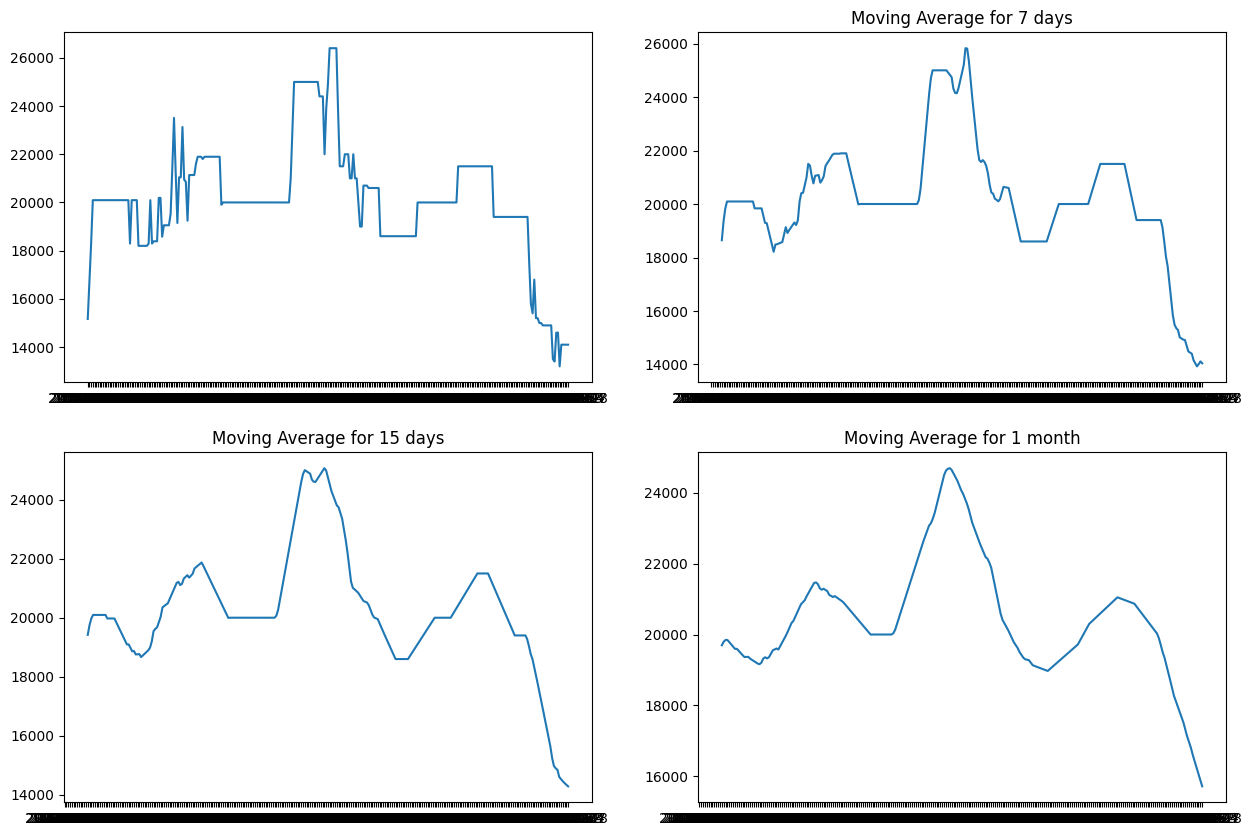

In [16]:
#show price changes for the first company in the list over 2022 till present day
print("Closing price change for:", selected_companies[0])
sample = dfs[0]
sample["Date"] = pd.to_datetime(sample['TradingDate'], format='mixed', dayfirst=True)
sample_2022 = sample[sample['Date'] >= '01-01-2022']
fig = visualize_change(sample_2022, "Close")

## Run Model on Sample data

Run price prediction for adjusted close price on different time windows and prediction periods

In [83]:
# !mkdir -p "saved_model/vnstock/"
# save_path = "saved_model/vnstock/"


In [18]:
window_sizes = 120
pred_time = 7
#predict closing price
for i in range(len(selected_companies)): 
    company_name = selected_companies[i]
    df = dfs[i]
    X, y = get_samples(df, window_size, feat_index = 4, target_pred = pred_time)
    X_train, X_test, X_val, y_train, y_test, y_val = preprocessing(X, y, window_size)
    X_train_norm, y_train_norm = norm_data(X_train, y_train)
    X_val_norm, y_val_norm = norm_data(X_val, y_val)
    model, val_loss, val_mse = train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time)
    test_mse = test_model(model, X_test, y_test)
#     filepath = save_path + company_name + "-close"
#     model.save(filepath)
    

3/3 [==============================] - 0s 16ms/step
MSE on the test set:  0.10955547793605729
3/3 [==============================] - 0s 18ms/step
MSE on the test set:  0.061540767469573154
3/3 [==============================] - 0s 16ms/step
MSE on the test set:  0.0700846006174297
3/3 [==============================] - 0s 20ms/step
MSE on the test set:  0.06026779486524741
4/4 [==============================] - 0s 18ms/step
MSE on the test set:  0.046770170155030884
3/3 [==============================] - 0s 20ms/step
MSE on the test set:  0.03833475121228103
3/3 [==============================] - 1s 25ms/step
MSE on the test set:  0.05756683227675874
3/3 [==============================] - 0s 22ms/step
MSE on the test set:  0.04842145292512777
3/3 [==============================] - 0s 28ms/step
MSE on the test set:  0.06659236326664555
4/4 [==============================] - 0s 19ms/step
MSE on the test set:  0.08138216353291612
4/4 [==============================] - 0s 18ms/step
MSE on 

3/3 [==============================] - 0s 25ms/step
MSE on the test set:  0.10674842868403632


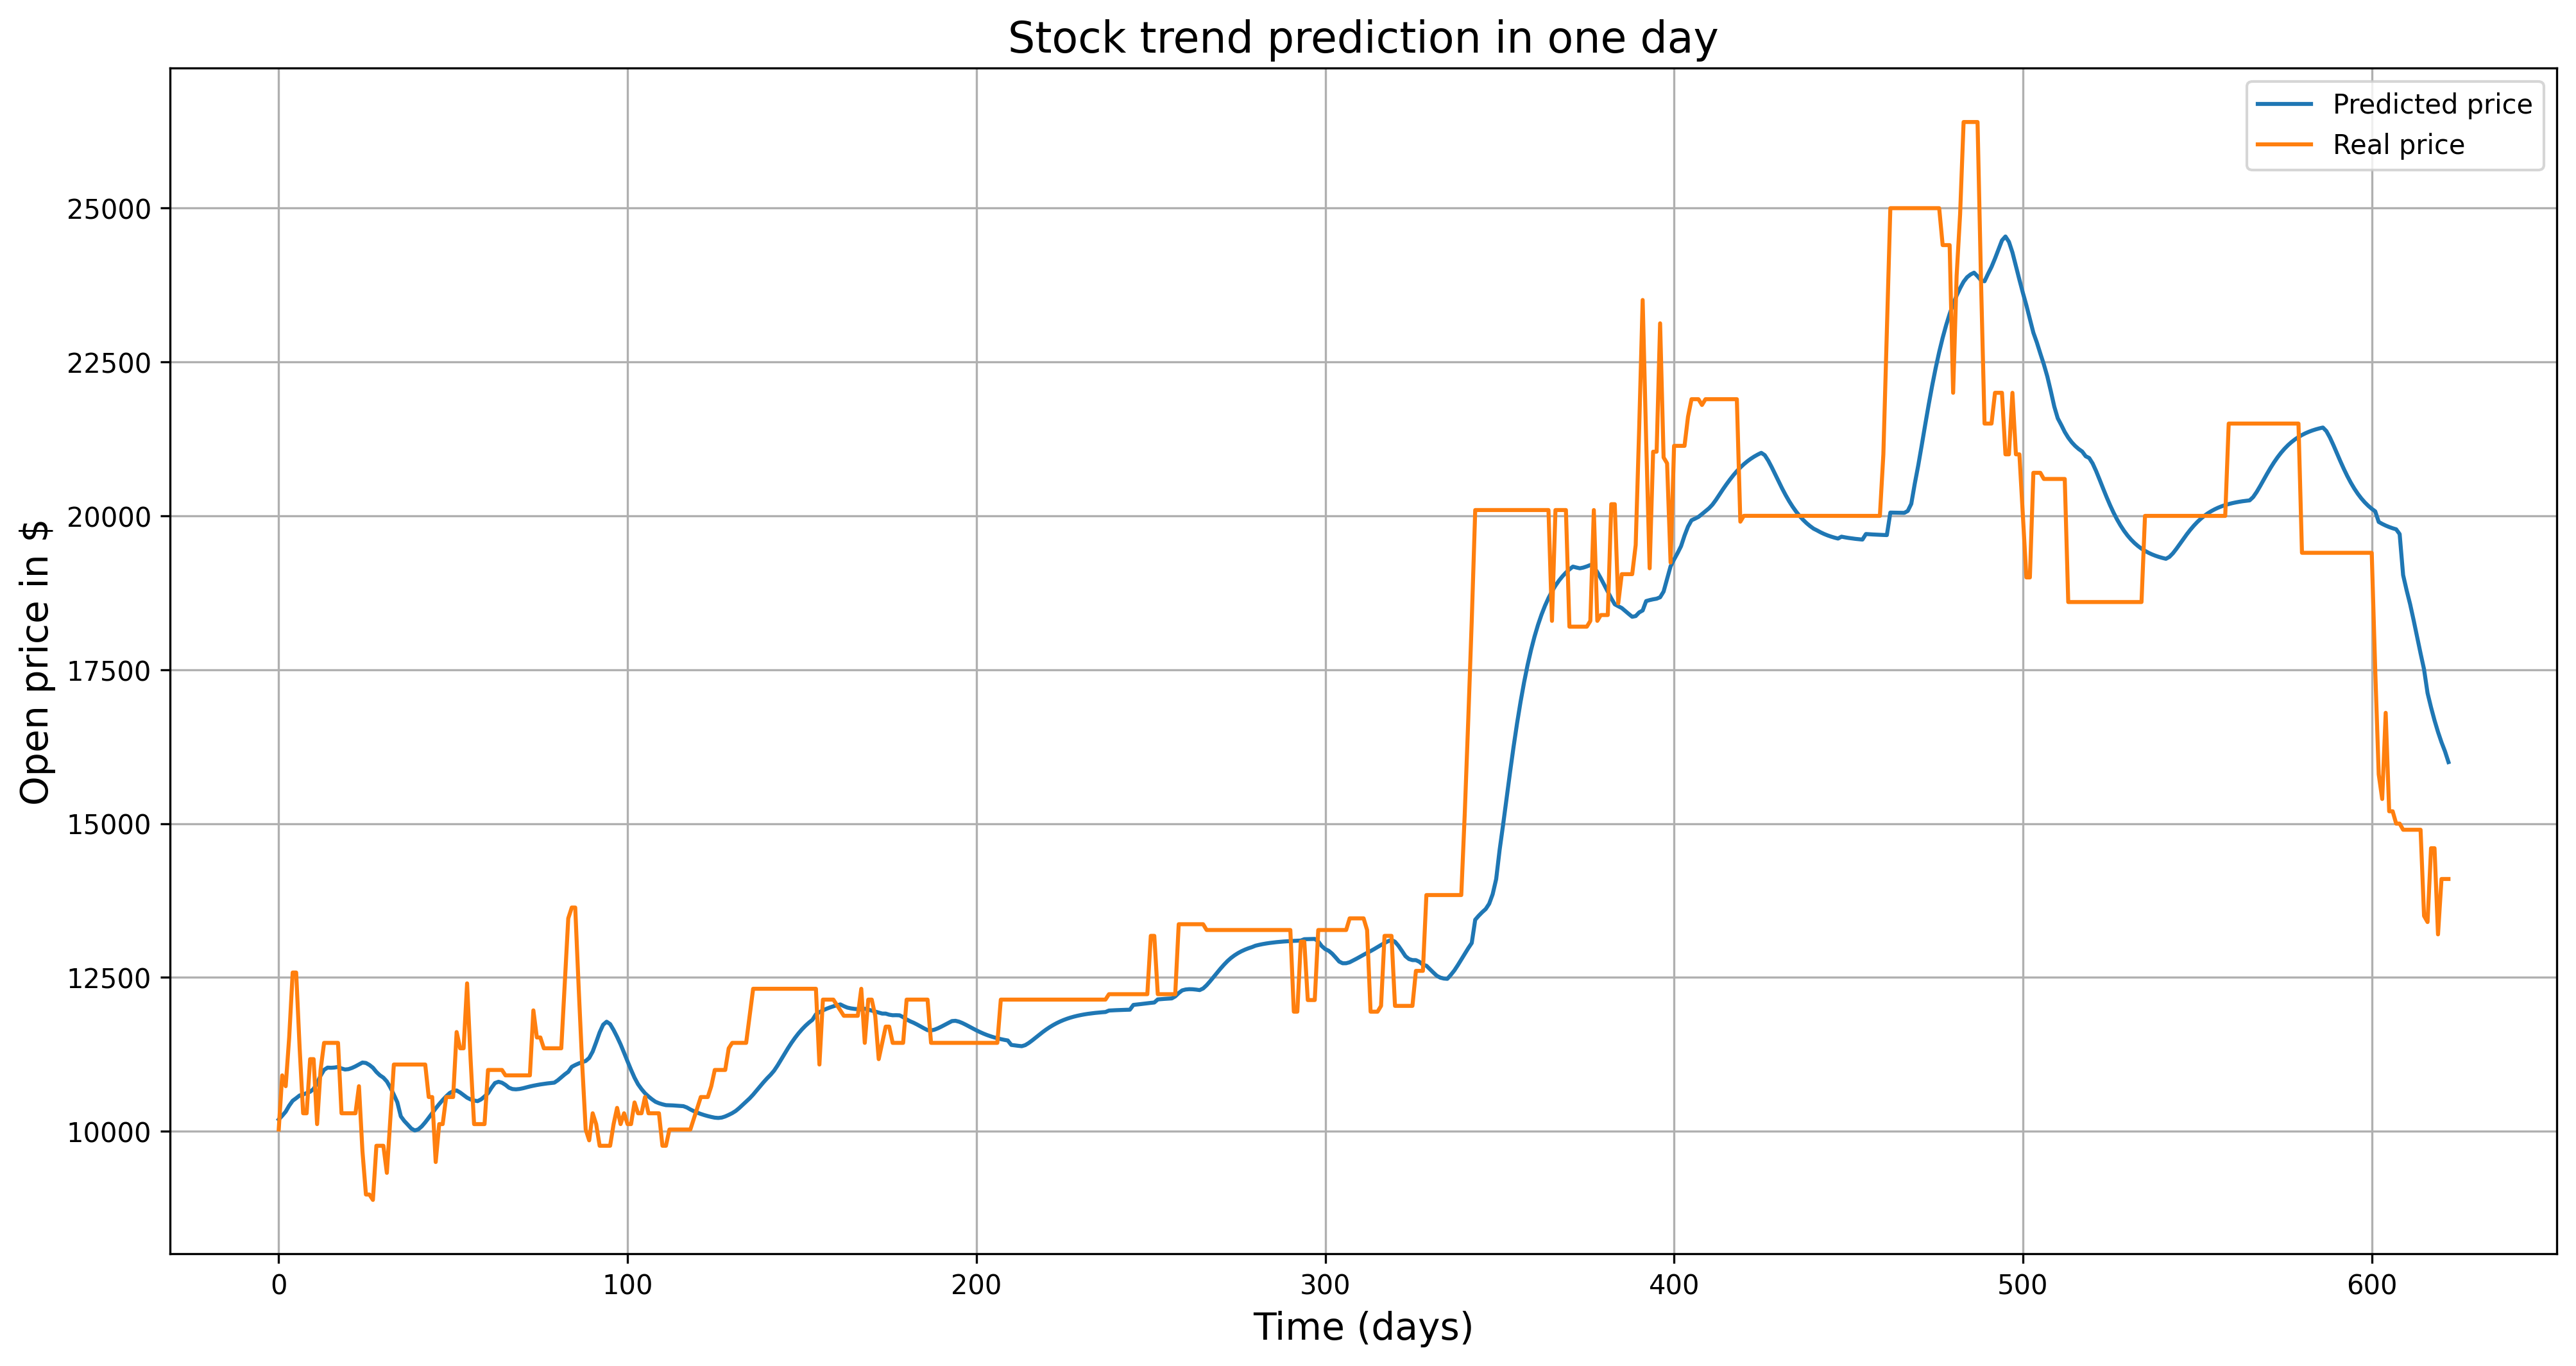

In [21]:
#Reconstruct test set
window_sizes = 120
pred_time = 7
df = dfs[0]
X, y = get_samples(df, window_size, feat_index = 4, target_pred = pred_time)
X_train, X_test, X_val, y_train, y_test, y_val = preprocessing(X, y, window_size)
test_mse = test_model(model, X_test, y_test, plot=True)


7/7 [==============================] - 0s 16ms/step
MSE on the test set:  0.11939711465559688


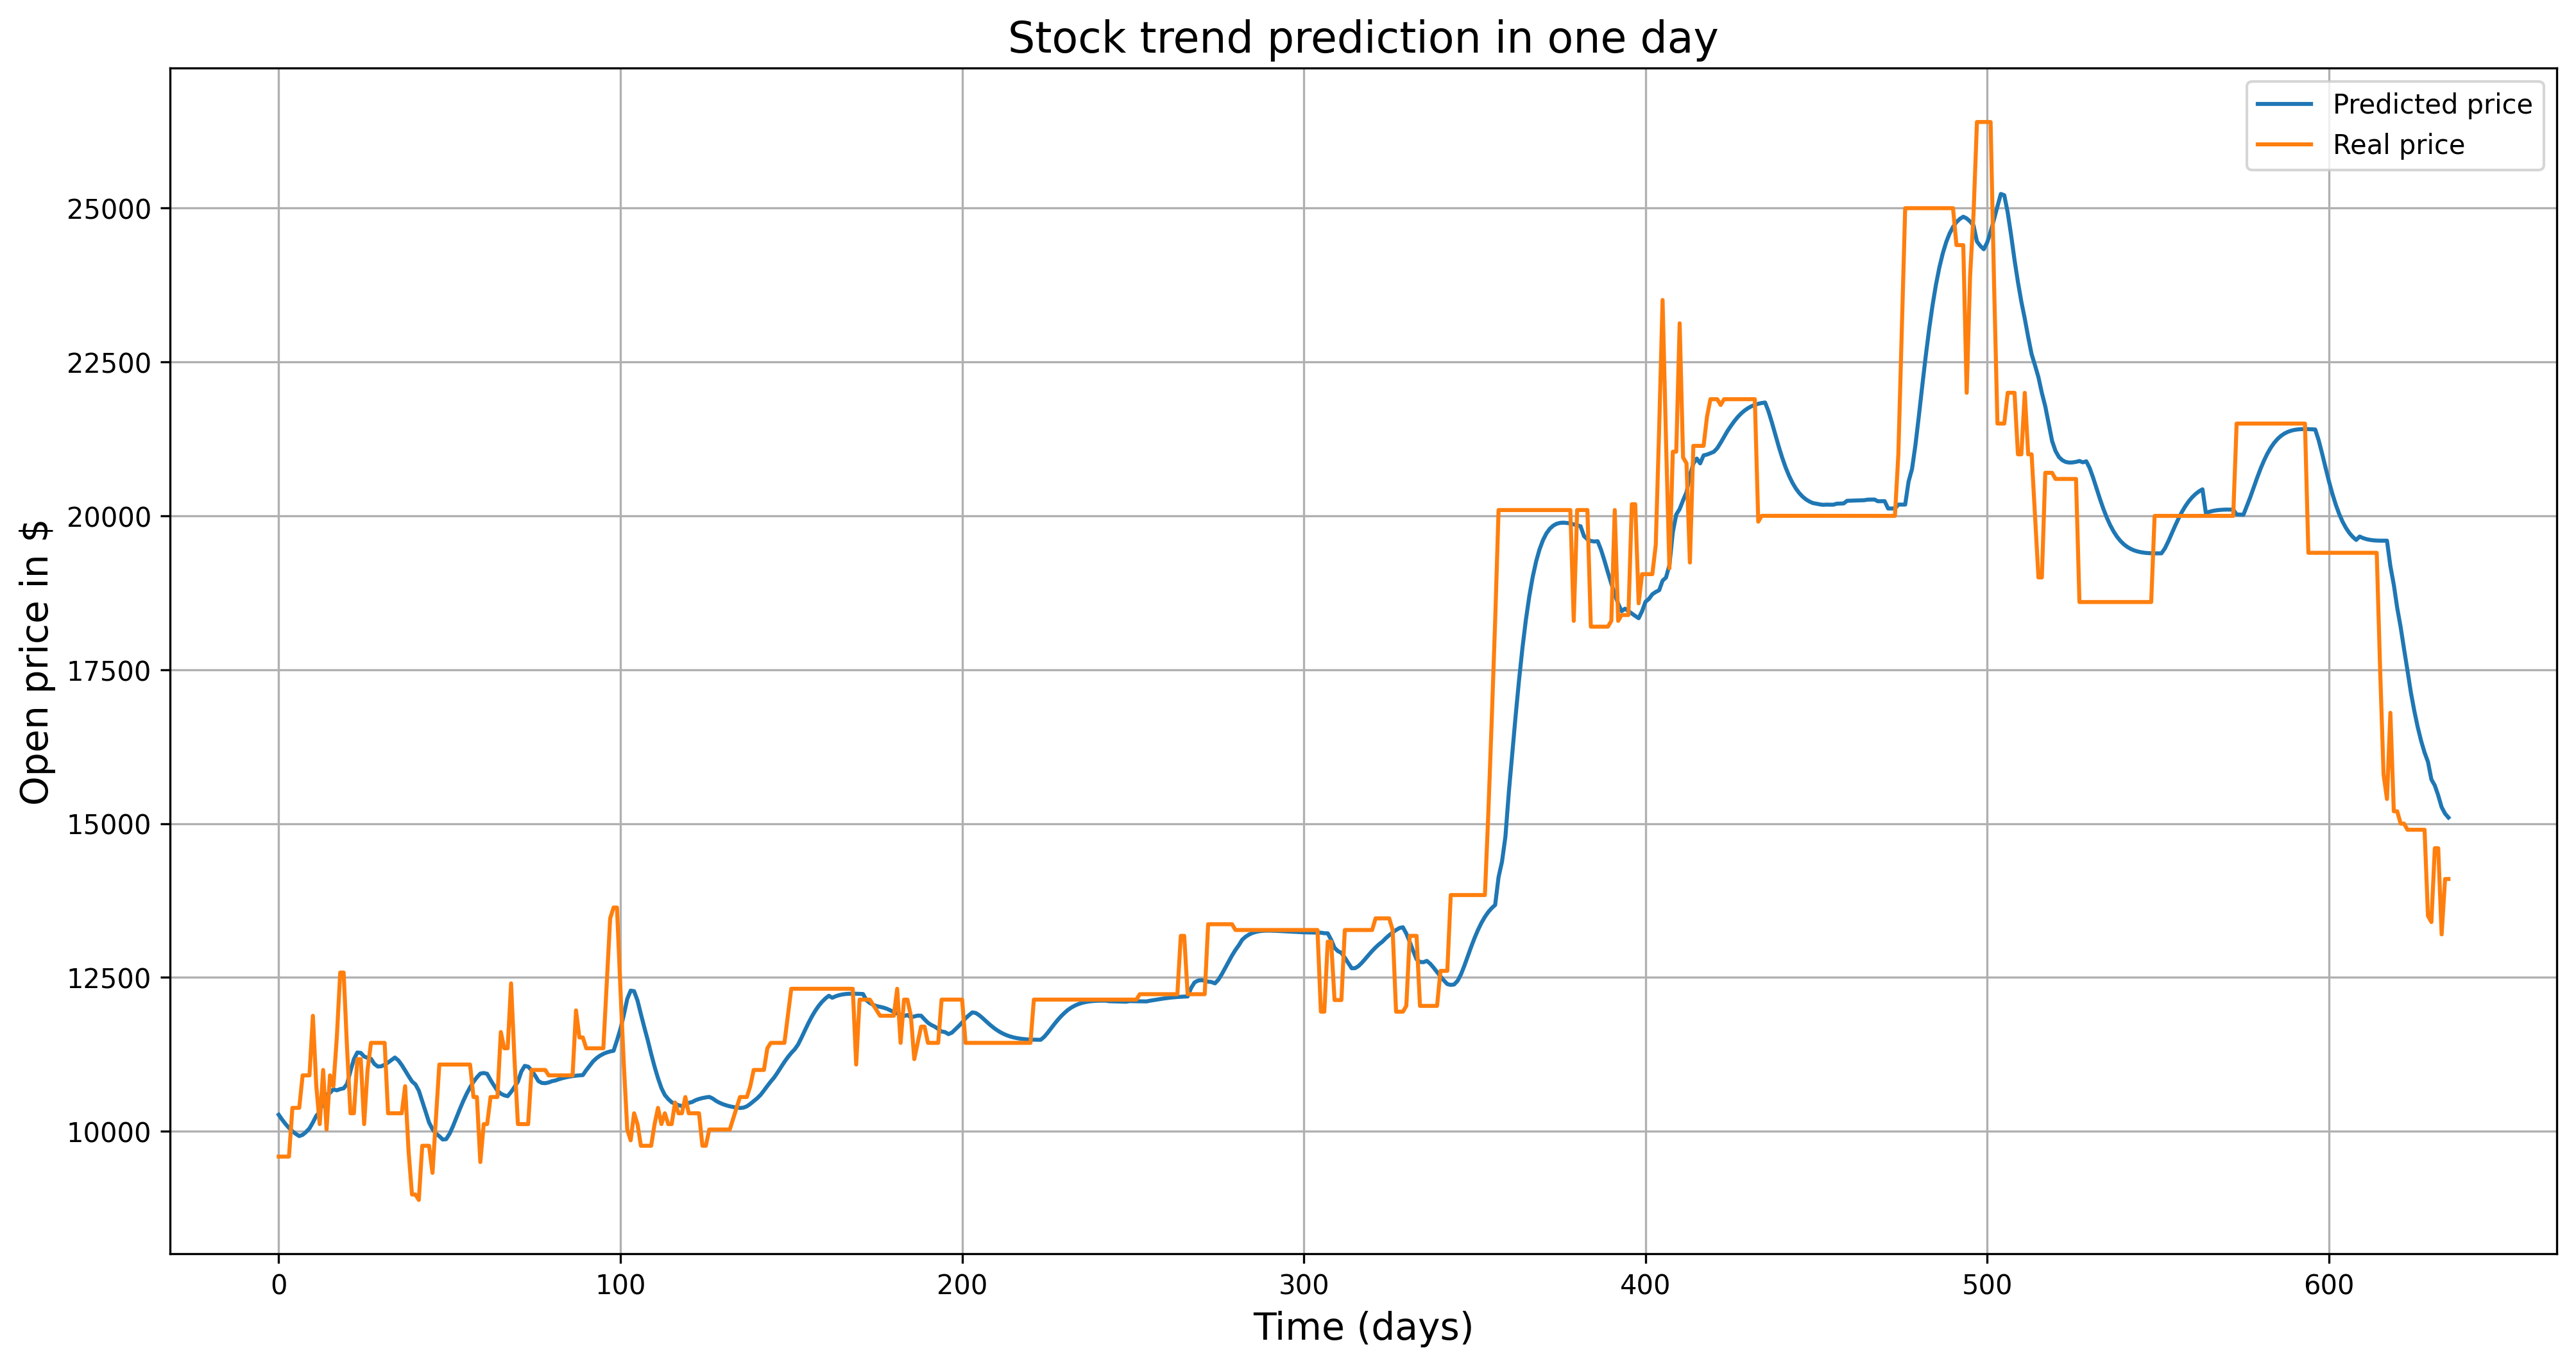

In [22]:
#Predict closing price for the same company, but on different time window and prediction period 
window_size = 60
pred_time = 3
#predict closing price
df = dfs[0]
X, y = get_samples(df, window_size, feat_index = 4, target_pred = pred_time)
X_train, X_test, X_val, y_train, y_test, y_val = preprocessing(X, y, window_size)
X_train_norm, y_train_norm = norm_data(X_train, y_train)
X_val_norm, y_val_norm = norm_data(X_val, y_val)
model, val_loss, val_mse = train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time)
test_mse = test_model(model, X_test, y_test, plot=True)


21/21 [==============================] - 0s 9ms/step
MSE on the test set:  1558.238520342119


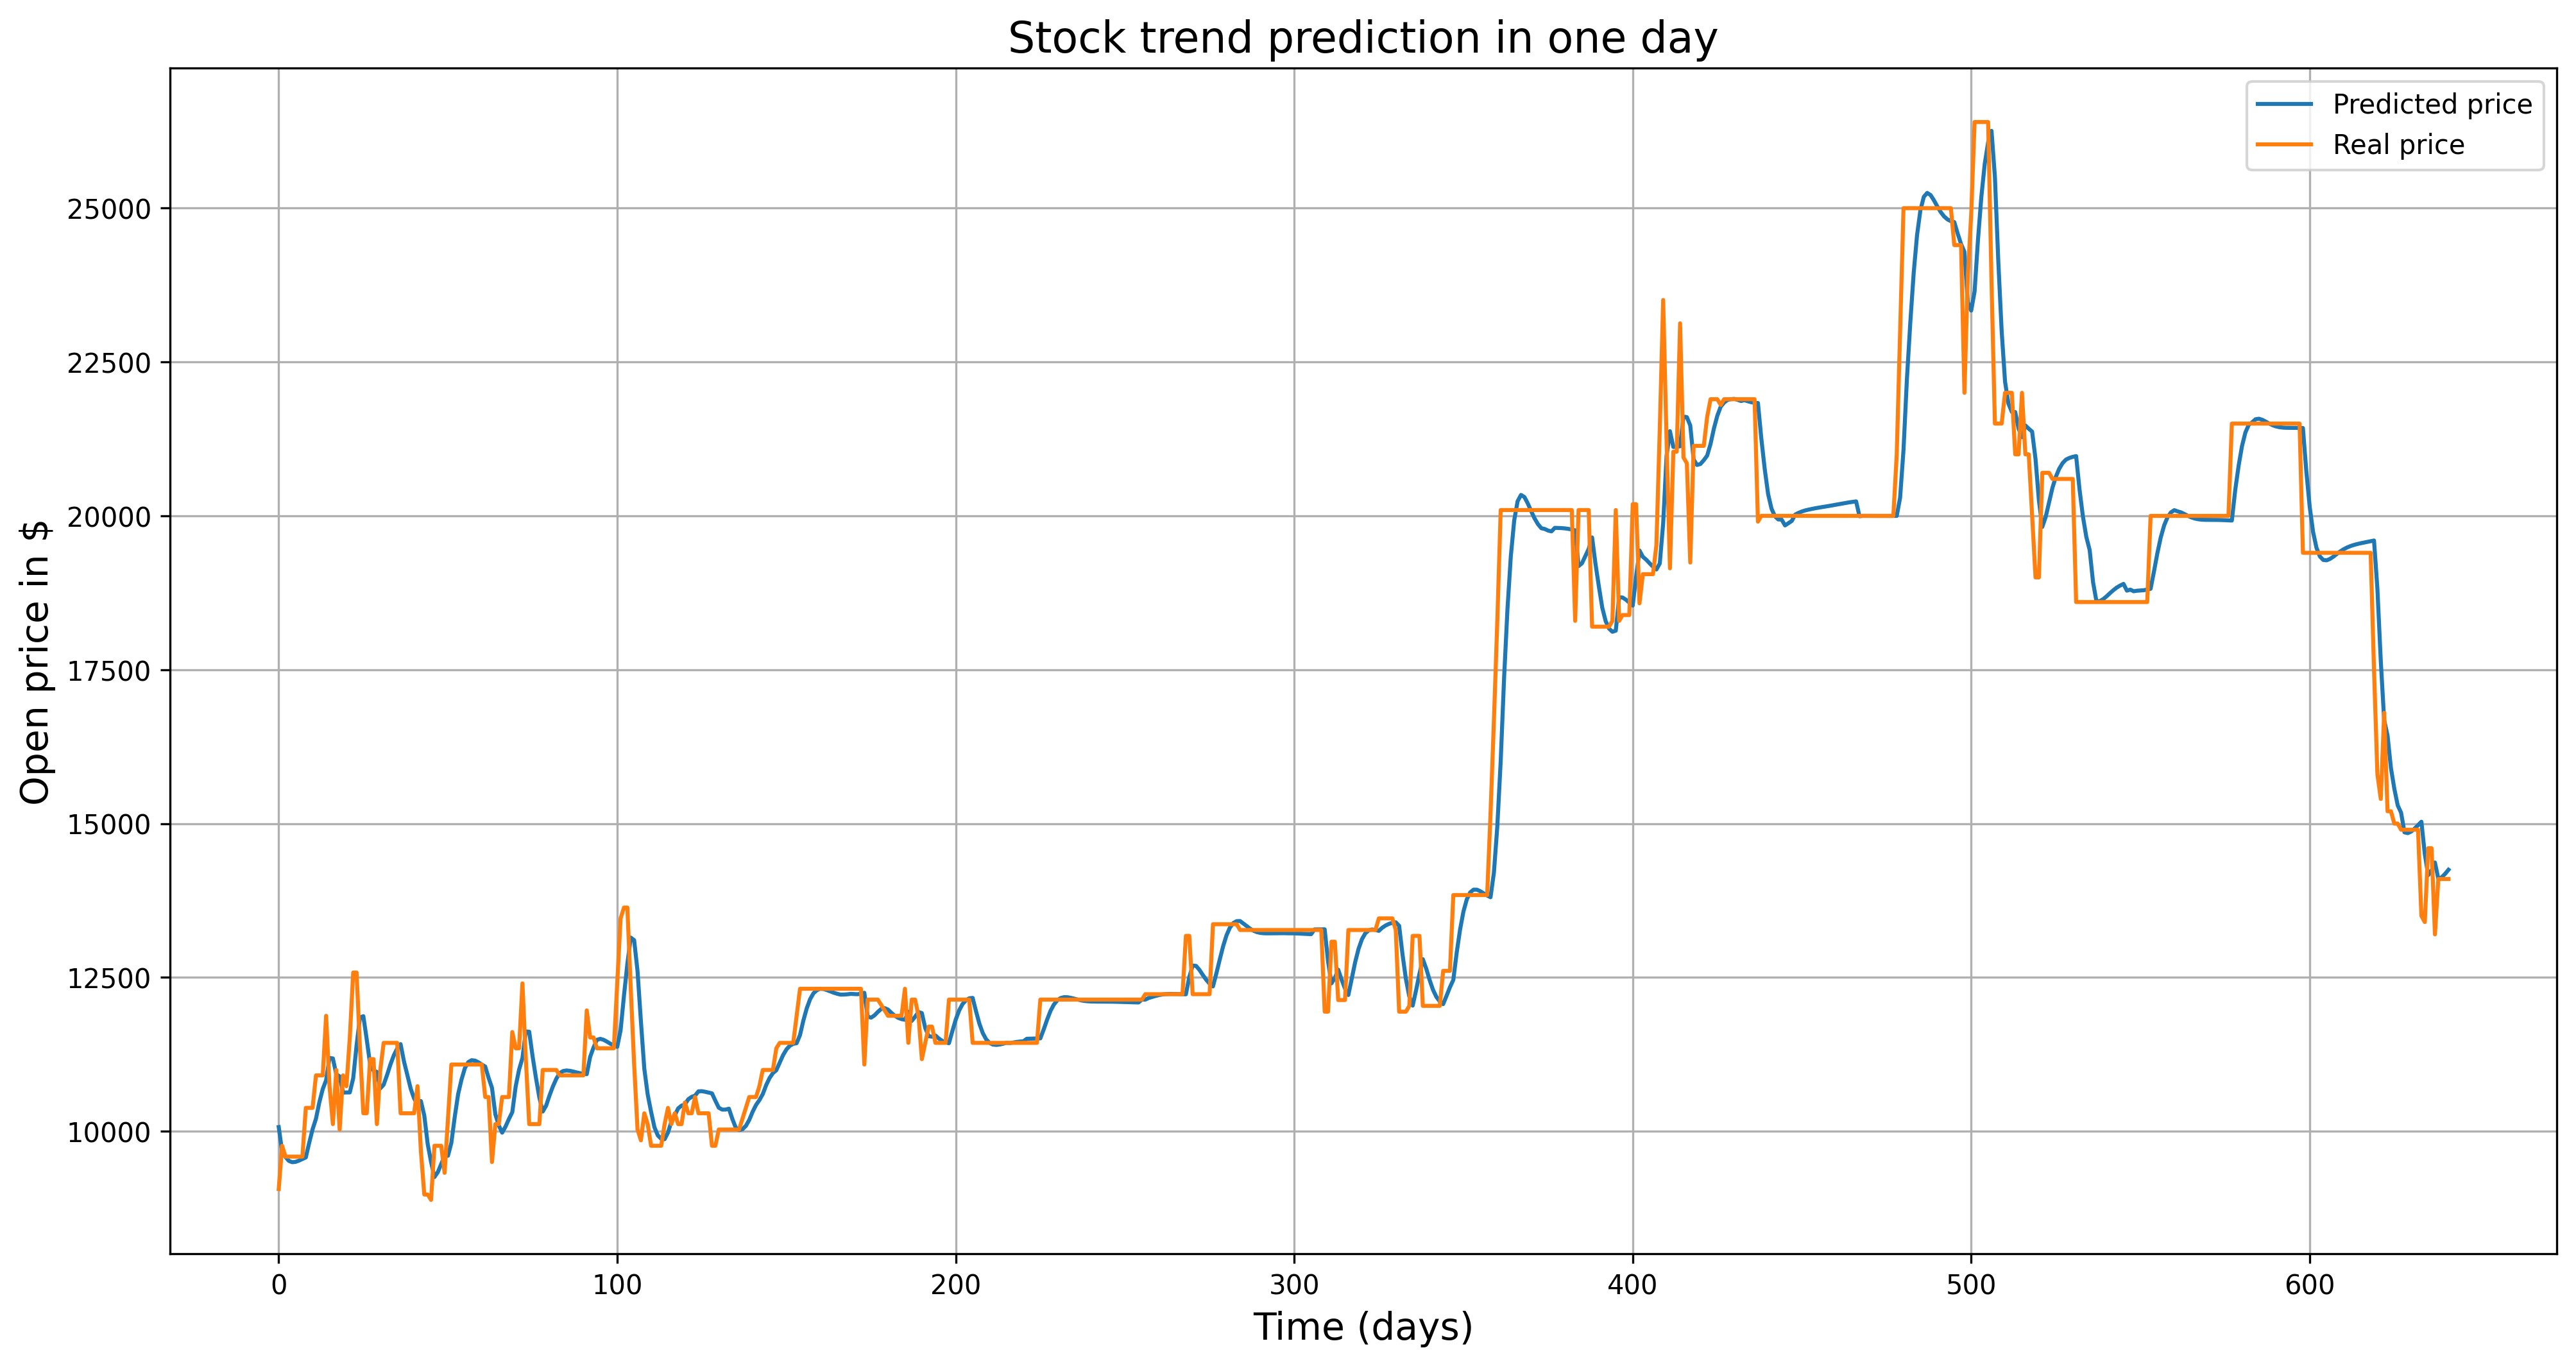

In [23]:
#Finally, testing with 30-day time window for next day prediction
window_size = 30
pred_time = 1
#predict closing price
df = dfs[0]
X, y = get_samples(df, window_size, feat_index = 4, target_pred = pred_time)
X_train, X_test, X_val, y_train, y_test, y_val = preprocessing(X, y, window_size)
X_train_norm, y_train_norm = norm_data(X_train, y_train)
X_val_norm, y_val_norm = norm_data(X_val, y_val)
model, val_loss, val_mse = train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time)
test_mse = test_model(model, X_test, y_test, plot=True)

## Cross validation 

In [25]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [28]:
def cross_validate(company): 
    window_size = 60
    pred_time = 3
    X, y = get_samples(sample, window_size, feat_index = 4, target_pred = pred_time)
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)
    X_train_norm, y_train_norm = norm_data(X_train, y_train)
    mses = []

    for n, (train_index, test_index) in enumerate(TimeSeriesSplit(n_splits=5).split(X_train, y_train)):
        print("On fold: --", n)
#         print("train_index", train_index , "test_index", test_index)
        X_val_fold, y_val_fold = X_train.copy()[test_index], y_train.copy()[test_index]
        X_train_fold, y_train_fold = X_train.copy()[train_index], y_train.copy()[train_index]
        X_train_fold_norm, y_train_fold_norm = norm_data(X_train_fold, y_train_fold)
        X_val_fold_norm, y_val_fold_norm = norm_data(X_val_fold, y_val_fold)
#         Print shape of the training, validation and test set
#         print("Shape of training set: ", X_train_fold.shape, y_train_fold.shape)
#         print("Shape of validation set: ", X_val_fold.shape, y_val_fold.shape)
#         print("Shape of test set:", X_test.shape, y_test.shape)

        # Create and train the model
        model, val_loss, val_mse = train_model(X_train_fold_norm, y_train_fold_norm, X_val_fold_norm, y_val_fold_norm, window_size, pred_time)
        test_mse = test_model(model, X_test, y_test, verbose=0)
        mses.append(test_mse)
    overall_mse = np.average(mses)
    print("Overall MSE: ", overall_mse)

In [29]:
#Cross validate for company with ticker CKV
cross_validate(dfs[0])

On fold: -- 0
MSE on the test set:  0.1679075701102958
On fold: -- 1
MSE on the test set:  0.14032589110977847
On fold: -- 2
MSE on the test set:  0.12962152110821604
On fold: -- 3
MSE on the test set:  0.12089980705033425
On fold: -- 4
MSE on the test set:  0.1127596839313673
Overall MSE:  0.13430289466199835
